<a href="https://colab.research.google.com/github/AugustinCablant/Stat-App/blob/main/MH_GIBBS_simulations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
#!pip install POT
#!pip install matplotlib
import ot
import numpy as np
import matplotlib.pyplot as plt

sigma=0.04
np.random.seed(123)

def proba_rejet(u,v,W,x,y,Z,T):
    u,v,W=histogramme(u),histogramme(v),histogramme(W)
    x,y,Z=histogramme(x),histogramme(y),histogramme(Z)
    return 1/(2*sigma**2)*(np.linalg.norm(T-ot.emd(u,v,W))**2-np.linalg.norm(T-ot.emd(x,y,Z))**2)

def in_hypercube(u,v,W):

    if any(x < 0 or x > 1 for x in u):
        return False

    if any(x < 0 or x > 1 for x in v):
        return False

    if any(any(x < 0 or x > 1 for x in row) for row in W):
        return False
    return True

def histogramme(x):
    # Normaliser la liste pour que la somme soit égale à 1
    somme = np.sum(x)
    histogramme = x / somme
    return histogramme

n = 10**4
def MH_gibbs(T):
    N = len(T)
    # Initialisation
    U, V, C = np.zeros((n, N)), np.zeros((n, N)), np.zeros((n, N, N))
    U[0] = np.random.uniform(size=N)
    V[0] = np.random.uniform(size=N)
    C[0, :, :] = np.random.uniform(size=(N, N))
    def fix_coord(x):
        for i in range(N): x[i,i]=10
        return x
    # Vecteurs aléatoires
    e_u, e_v,e_C  = np.random.normal(0, 0.02, (N, n)), np.random.normal(0, 0.02, (N, n)), np.random.normal(0, 0.04, (N, N, n))
    u_u, u_v, u_c  = np.log(np.random.uniform(size=n)), np.log(np.random.uniform(size=n)), np.log(np.random.uniform(size=n))

    acceptance_rate = 0
    running_average = np.zeros(n)

    for k in range(n-1):
        # Pas pour U
        x, y, Z = U[k] + e_u[:, k], V[k], C[k]
        if not in_hypercube(x, y, Z): U[k+1], V[k+1], C[k+1] = U[k], V[k], C[k]
        else:
            if u_u[k] < proba_rejet(U[k], V[k], C[k], x, y, Z,T):
                U[k+1], V[k+1], C[k+1] = x, y, Z
                acceptance_rate += 1
            else: U[k+1], V[k+1], C[k+1] = U[k], V[k], C[k]
        UK=U[k+1]
        # Pas pour V
        x, y, Z = UK, V[k] + e_v[:, k], C[k]
        if not in_hypercube(x, y, Z): U[k+1], V[k+1], C[k+1] = UK, V[k], C[k]
        else:
            if u_v[k] < proba_rejet(UK, V[k], C[k], x, y, Z,T):
                U[k+1], V[k+1], C[k+1] = x, y, Z
                acceptance_rate += 1
            else: U[k+1], V[k+1], C[k+1] = UK, V[k], C[k]
        VK=V[k+1]
        # Pas pour C
        x, y, Z = UK, VK, fix_coord(C[k] + e_C[:, :, k])
        if not in_hypercube(x, y, Z):
            U[k+1], V[k+1], C[k+1] = UK, VK, C[k]
        else:
            if u_c[k] < proba_rejet(U[k], V[k], C[k], x, y, Z,T):
                U[k+1], V[k+1], C[k+1] = x, y, Z
                acceptance_rate += 1
            else: U[k+1], V[k+1], C[k+1] = UK, VK, C[k]

        # Calcul du running average
        running_average[k+1] = ((k+1) * running_average[k] + acceptance_rate) / (k+2)

    acceptance_rate /= (3 * n)
    return U, V, C, acceptance_rate, running_average

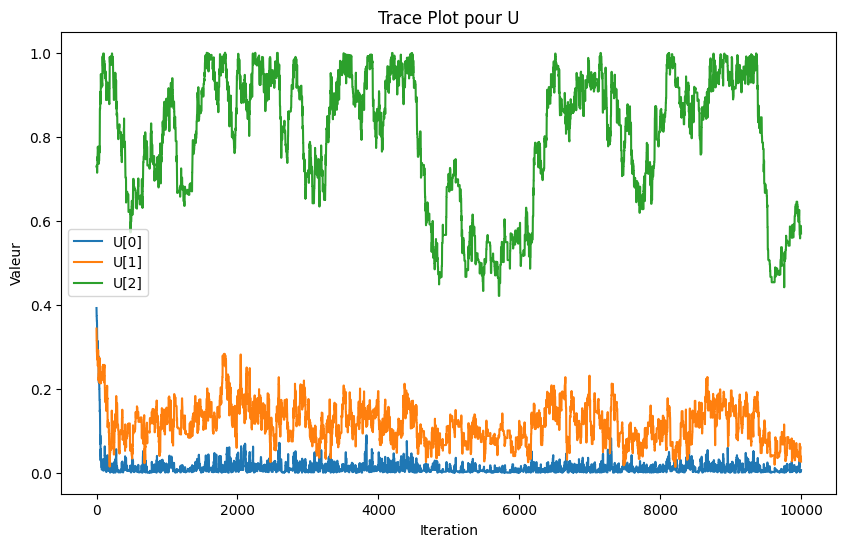

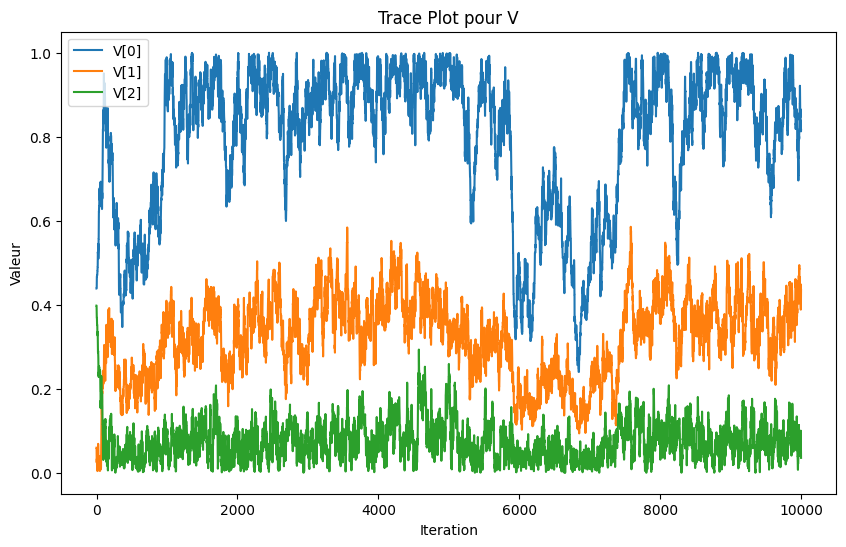

Taux d'acceptation : 0.33836666666666665
Running average : [0.00000000e+00 5.00000000e-01 1.00000000e+00 ... 5.12879546e+03
 5.12929763e+03 5.12979980e+03]


In [5]:
T = np.random.uniform(size=(3, 3))

# Simulation
U, V, C, acceptance_rate, running_average = MH_gibbs(T)

# Trace plot pour U
plt.figure(figsize=(10, 6))
for i in range(len(U[0])):
    plt.plot(U[:, i], label=f"U[{i}]")
plt.title("Trace Plot pour U")
plt.xlabel("Iteration")
plt.ylabel("Valeur")
plt.legend()
plt.show()

# Trace plot pour V
plt.figure(figsize=(10, 6))
for i in range(len(U[0])):
    plt.plot(V[:, i], label=f"V[{i}]")
plt.title("Trace Plot pour V")
plt.xlabel("Iteration")
plt.ylabel("Valeur")
plt.legend()
plt.show()

print(f"Taux d'acceptation : {acceptance_rate}")
print("Running average :", running_average)
